In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from tabulate import tabulate
from termcolor import colored as cl
import random
from typing import List, Tuple, Dict, Optional
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import flwr as fl
from flwr.common import Context
from imblearn.over_sampling import SMOTE
from flwr.common import parameters_to_ndarrays
from flwr.common import ndarrays_to_parameters
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import ray
import torch.nn as nn
import torch.nn.functional as F
from scipy.interpolate import make_interp_spline, interp1d

E0000 00:00:1745414391.412833 1056745 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745414391.416680 1056745 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 08:19:53,307	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/user/anaconda3/lib/python3.12/site-packages/rdt/transformers/utils.py:14: DeprecationWarning: module 'sre_parse' is deprecated
  import sre_parse  # isort:skip


In [3]:
NUM_CLIENTS = 15
LOCAL_EPOCHS_LIST= [1,2,3,4,5]
NUM_ROUNDS = 10

In [ ]:
data = pd.read_csv('./data/EVSE_augmented_1.5.csv')

In [5]:
# # data.describe()
# !pip install Model

In [6]:
data.head()

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,ChargingState,Attack,Scenario,Label,interface
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any


In [7]:
data["Label"].unique()

array(['attack', 'benign'], dtype=object)

In [8]:
cases = len(data)
benign_count = len(data[data.Label == "benign"])
attack_count = len(data[data.Label == "attack"])
anomolies_percentage = round(attack_count/cases*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Benign cases are {}'.format(benign_count), attrs = ['bold']))
print(cl('Number of attack cases are {}'.format(attack_count), attrs = ['bold']))
print(cl('Percentage of attack cases is {}'.format(anomolies_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 12702
Number of Benign cases are 3454
Number of attack cases are 9248
Percentage of attack cases is 72.81
--------------------------------------------


In [9]:
data.duplicated().sum()

0

In [10]:
data = data.drop_duplicates()

In [11]:
total_rows = data.shape[0]
missing_columns = [col for col in data.columns if data[col].isnull().sum()>0]
for col in missing_columns:
  null_count = data[col].isnull().sum()
  per = (null_count/total_rows) * 100
  print(f"{col}: {null_count} ({round(per,3)}%)")

raw_syscalls_sys_enter: 2 (0.016%)
raw_syscalls_sys_exit: 3 (0.024%)
syscalls_sys_enter_arm64_personality: 5 (0.039%)
syscalls_sys_enter_capget: 4 (0.031%)
syscalls_sys_enter_capset: 2 (0.016%)
syscalls_sys_enter_clone: 3 (0.024%)
syscalls_sys_enter_clone3: 4 (0.031%)
syscalls_sys_enter_exit: 2 (0.016%)
syscalls_sys_enter_exit_group: 3 (0.024%)
syscalls_sys_enter_mmap: 2 (0.016%)
syscalls_sys_enter_rt_sigreturn: 3 (0.024%)
syscalls_sys_enter_set_tid_address: 3 (0.024%)
syscalls_sys_enter_unshare: 5 (0.039%)
syscalls_sys_enter_wait4: 2 (0.016%)
syscalls_sys_enter_waitid: 3 (0.024%)
syscalls_sys_exit_arm64_personality: 2 (0.016%)
syscalls_sys_exit_capget: 4 (0.031%)
syscalls_sys_exit_capset: 3 (0.024%)
syscalls_sys_exit_clone: 2 (0.016%)
syscalls_sys_exit_clone3: 3 (0.024%)
syscalls_sys_exit_exit: 3 (0.024%)
syscalls_sys_exit_exit_group: 2 (0.016%)
syscalls_sys_exit_mmap: 2 (0.016%)
syscalls_sys_exit_ptrace: 2 (0.016%)
syscalls_sys_exit_rt_sigreturn: 2 (0.016%)
syscalls_sys_exit_set_tid_

In [12]:
# Impute missing values using the mean for the specified columns
imputer = SimpleImputer(strategy='mean')

for col in missing_columns:
    data[col] = imputer.fit_transform(data[[col]])

data

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,ChargingState,Attack,Scenario,Label,interface
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12697,3606.096204,0,0,0,0,0,314710680,2793,0,0,...,0,0,0,0,0,Charging,cryptojacking,Benign,attack,any
12698,1676.161152,0,0,0,0,0,225297323,3612,0,0,...,0,0,0,0,0,idle,cryptojacking,Benign,attack,none
12699,44.944882,0,0,0,0,0,44789343,3726,0,0,...,0,0,0,0,0,Charging,port-scan,DoS,attack,ocpp
12700,2645.700642,0,0,0,0,0,167412921,4291,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,benign,iso15118


In [13]:
def one_hot_encode(data):
    data = pd.get_dummies(data, columns=['ChargingState'], drop_first=True)
    return data

data = one_hot_encode(data)

def label_encode(data):
    for col in data.columns:
        if col == "Label":
            data["Label"] = data["Label"].map({'benign':0, 'attack':1})
        elif data[col].dtype == "object" and col != "ChargingState":
            data[col] = data[col].astype(str)
            label_encoder = LabelEncoder()
            data[col] = label_encoder.fit_transform(data[col])
    return data

data = label_encode(data)

data.head()

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,Attack,Scenario,Label,interface,ChargingState_idle
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,2,1,1,0,False
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,2,1,1,0,False
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,2,1,1,0,False
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,2,1,1,0,False
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,2,1,1,0,False


In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(data.drop('Label', axis=1))


In [15]:
# X_data = data.drop('Label', axis=1)
y= data['Label']


In [16]:
# X = Features, y = Labels (0=benign, 1=attack)
smote = SMOTE(sampling_strategy={0: 6166})  # Oversample benign (0) to match attack (1) count
X_balanced, y_balanced = smote.fit_resample(X, y)


In [17]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


In [18]:
def split_data_noniid(X, y, num_clients):
    # Convert to numpy arrays if needed
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.Series) else y


    benign_indices = np.where(y == 0)[0]
    attack_indices = np.where(y == 1)[0]


    np.random.shuffle(benign_indices)
    np.random.shuffle(attack_indices)


    total_attack = len(attack_indices)
    total_benign = len(benign_indices)
    total_samples = min(total_attack, total_benign) * 2  # Ensure 50-50 use


    # Truncate to balance
    attack_indices = attack_indices[:total_samples // 2]
    benign_indices = benign_indices[:total_samples // 2]


    # Define diverse per-client attack ratios (e.g., linearly spaced between 0.1 and 0.9)
    attack_ratios = np.linspace(0.1, 0.9, num_clients)


    # Compute sample counts for each client based on desired ratio
    client_datasets = []
    attack_cursor, benign_cursor = 0, 0
    attack_used, benign_used = 0, 0


    total_attack_remaining = len(attack_indices)
    total_benign_remaining = len(benign_indices)


    total_samples_per_client = total_samples // num_clients


    for i in range(num_clients):
        ratio = attack_ratios[i]
        num_attack = int(total_samples_per_client * ratio)
        num_benign = total_samples_per_client - num_attack


        # Make sure we don't go out of bounds
        if attack_cursor + num_attack > total_attack_remaining:
            num_attack = total_attack_remaining - attack_cursor
        if benign_cursor + num_benign > total_benign_remaining:
            num_benign = total_benign_remaining - benign_cursor


        client_attack = attack_indices[attack_cursor:attack_cursor + num_attack]
        client_benign = benign_indices[benign_cursor:benign_cursor + num_benign]


        attack_cursor += num_attack
        benign_cursor += num_benign


        client_indices = np.concatenate([client_attack, client_benign])
        np.random.shuffle(client_indices)


        client_datasets.append((X[client_indices], y[client_indices]))


    return client_datasets, attack_ratios


client_datasets, attack_ratios_used = split_data_noniid(X_train, y_train, num_clients=NUM_CLIENTS)


In [19]:
def reset_logfile():
    for cid in range(NUM_CLIENTS):
        log_file_accuracy = f"output/FedAvgM/client_{cid}_clients_{NUM_CLIENTS}.epochs_accuracy_FedAvgM.log"
        log_file_loss = f"output/FedAvgM/client_{cid}_clients_{NUM_CLIENTS}.epochs_loss_FedAvgM.log"
        if os.path.exists(log_file_accuracy):
            os.remove(log_file_accuracy)
        if os.path.exists(log_file_loss):
            os.remove(log_file_loss)
            

In [20]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [21]:
class FLClient(fl.client.NumPyClient):
    def __init__(self, model, train_data, local_epochs,cid):
        self.model = model
        self.train_data = train_data
        self.local_epochs = local_epochs
        self.cid = cid
   
    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        X, y = self.train_data
        self.model.fit(X, y, epochs=self.local_epochs, batch_size=32, verbose=0)
        return self.model.get_weights(), len(X), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        X, y = self.train_data
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
    
        # Predictions and classification
        y_pred_probs = self.model.predict(X, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype("int32")
    
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
    
        print(f"[Client {self.cid} Eval] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
        # Logging
        with open(f"output/FedAvgM/client_{self.cid}_clients_{NUM_CLIENTS}.epochs_accuracy_FedAvgM.log", "a") as f:
            f.write(f"{accuracy}\n")
        with open(f"output/FedAvgM/client_{self.cid}_clients_{NUM_CLIENTS}.epochs_loss_FedAvgM.log", "a") as f:
            f.write(f"{loss}\n")
    
        return loss, len(X), {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }


In [22]:
def client_fn(cid: str):
    cid_int = int(cid)
    model = create_model()
    return FLClient(model, client_datasets[cid_int], LOCAL_EPOCHS_LIST[int(cid_int % 5)], cid)

In [23]:
def weighted_average(metrics):
    total_examples = sum(num_examples for num_examples, _ in metrics)

    # Initialize accumulators for each metric
    aggregated = {
        "accuracy": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "f1_score": 0.0
    }

    for num_examples, m in metrics:
        for key in aggregated:
            aggregated[key] += m[key] * num_examples

    # Final weighted average
    for key in aggregated:
        aggregated[key] /= total_examples

    return aggregated

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 28 * 28)))
        return self.fc2(x)

In [25]:
model = Net()
initial_weights = [val.cpu().numpy() for _, val in model.state_dict().items()]
initial_parameters = ndarrays_to_parameters(initial_weights)

In [26]:
class ModelAggregrate(fl.server.strategy.FedAvg):
    def __init__(self, 
                 momentum: float = 0.2,
                 **kwargs):
        super().__init__(**kwargs)
        self.momentum = momentum
        self.velocity = None
        self.previous_weights = None
        self.round_counter = 0
        self.final_weights = None

    def aggregate_fit(self, 
                    server_round: int,
                    results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
                    failures: List[BaseException]) -> Tuple[Optional[fl.common.Parameters], Dict[str, fl.common.Scalar]]:
        self.round_counter += 1
        
        random.seed(server_round)
        np.random.seed(server_round)

        # Convert all results to numpy arrays
        weights_results = []
        for client, fit_res in results:
            weights = fl.common.parameters_to_ndarrays(fit_res.parameters)
            
            weights_results.append((weights, fit_res.num_examples))

        # Perform weighted average aggregation (using FedAvg's implementation)
        aggregated_weights = [
            np.average(
                [weights[i] for weights, _ in weights_results],
                axis=0,
                weights=[num_examples for _, num_examples in weights_results]
            )
            for i in range(len(weights_results[0][0]))
        ]

        if aggregated_weights:
            # Initialize velocity if first round
            if self.velocity is None:
                self.velocity = [np.zeros_like(w) for w in aggregated_weights]
                self.previous_weights = [w.copy() for w in aggregated_weights]
                return fl.common.ndarrays_to_parameters(aggregated_weights), {}

            # Apply momentum 
            weight_updates = [
                w_new - w_old for w_new, w_old in 
                zip(aggregated_weights, self.previous_weights)
            ]
            
            # Update velocity: v_t = m*v_{t-1} + Δw
            self.velocity = [
                self.momentum * v + (1- self.momentum) * u
                for v, u in zip(self.velocity, weight_updates)
            ]
            
            # Apply momentum: w_t = w_t + v_t
            aggregated_weights = [
                 w + v for w, v in zip(aggregated_weights, self.velocity)
            ]
            
            # Store current weights for next round
            self.previous_weights = [w.copy() for w in aggregated_weights]
            self.final_weights = fl.common.ndarrays_to_parameters(aggregated_weights)  # Save for later use

            return fl.common.ndarrays_to_parameters(aggregated_weights), {}

        return None, {}

# Usage
strategy = ModelAggregrate(
    momentum=0.2,
    fraction_fit=1,
    min_fit_clients=int(NUM_CLIENTS),
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,
)



In [27]:
reset_logfile()

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    ray_init_args={"num_cpus": 1},  # Limits overall Ray CPU allocation
    client_resources={"num_cpus": 1},  # Ensures controlled task scheduling
    strategy=strategy,
)

ray.shutdown()

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-04-23 08:20:14,830	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:10.0.5.98': 1.0, 'memory': 10273620788.0, 'node:__internal_head__': 1.0, 'object_store_memory': 5136810393.0, 'CPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 acto

(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.8921, Precision: 0.7397, Recall: 0.7660, F1: 0.7526


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.8465, Precision: 0.9522, Recall: 0.7896, F1: 0.8633


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.8450, Precision: 0.9792, Recall: 0.8201, F1: 0.8926
(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.8982, Precision: 0.6452, Recall: 0.7767, F1: 0.7048


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.8754, Precision: 0.8350, Recall: 0.7731, F1: 0.8029


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.8374, Precision: 0.9745, Recall: 0.7975, F1: 0.8772


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.8693, Precision: 0.9037, Recall: 0.8267, F1: 0.8635
(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.8967, Precision: 0.9627, Recall: 0.8470, F1: 0.9012


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9073, Precision: 0.8268, Recall: 0.8315, F1: 0.8291


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.8678, Precision: 0.8578, Recall: 0.7866, F1: 0.8206


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.8739, Precision: 0.8910, Recall: 0.8144, F1: 0.8510
(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.8602, Precision: 0.9915, Recall: 0.8412, F1: 0.9102


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9286, Precision: 0.6023, Recall: 0.8154, F1: 0.6928


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.8541, Precision: 0.9576, Recall: 0.8186, F1: 0.8826


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.8024, Precision: 0.9915, Recall: 0.7872, F1: 0.8776


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9271, Precision: 0.9961, Recall: 0.9170, F1: 0.9549
(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.8982, Precision: 0.9925, Recall: 0.8936, F1: 0.9404


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9347, Precision: 0.6170, Recall: 0.8923, F1: 0.7296


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9073, Precision: 0.6567, Recall: 0.8544, F1: 0.7426


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.8982, Precision: 0.9640, Recall: 0.8935, F1: 0.9274


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9043, Precision: 0.8545, Recall: 0.9051, F1: 0.8791
(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9103, Precision: 0.7531, Recall: 0.8652, F1: 0.8053


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9119, Precision: 0.8527, Recall: 0.8843, F1: 0.8682


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9392, Precision: 0.9553, Recall: 0.9344, F1: 0.9448


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9134, Precision: 0.9331, Recall: 0.8906, F1: 0.9114


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9073, Precision: 0.9657, Recall: 0.8934, F1: 0.9282
(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9012, Precision: 0.9788, Recall: 0.8936, F1: 0.9343


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9301, Precision: 0.9181, Recall: 0.9244, F1: 0.9212


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9195, Precision: 0.8109, Recall: 0.9157, F1: 0.8602


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9103, Precision: 0.9625, Recall: 0.8886, F1: 0.9241


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9149, Precision: 0.7877, Recall: 0.9382, F1: 0.8564
(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9331, Precision: 0.9639, Recall: 0.9257, F1: 0.9444


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9468, Precision: 0.9559, Recall: 0.9481, F1: 0.9520
(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9195, Precision: 0.7619, Recall: 0.9078, F1: 0.8285


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9149, Precision: 0.8635, Recall: 0.9249, F1: 0.8931


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9377, Precision: 0.9923, Recall: 0.9332, F1: 0.9619


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9271, Precision: 0.9323, Recall: 0.9210, F1: 0.9266


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9043, Precision: 0.6408, Recall: 0.8835, F1: 0.7429


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9088, Precision: 0.8391, Recall: 0.8935, F1: 0.8655


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9240, Precision: 0.5714, Recall: 0.9231, F1: 0.7059


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9240, Precision: 0.9927, Recall: 0.9223, F1: 0.9562


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9119, Precision: 0.9667, Recall: 0.9102, F1: 0.9376


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9255, Precision: 0.9088, Recall: 0.9244, F1: 0.9165


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9027, Precision: 0.9542, Recall: 0.8980, F1: 0.9252


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9271, Precision: 0.9815, Recall: 0.9246, F1: 0.9522


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9331, Precision: 0.8490, Recall: 0.9157, F1: 0.8811


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9255, Precision: 0.8884, Recall: 0.8843, F1: 0.8863


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9179, Precision: 0.6992, Recall: 0.8350, F1: 0.7611


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9134, Precision: 0.9731, Recall: 0.9061, F1: 0.9384


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9407, Precision: 0.9315, Recall: 0.9347, F1: 0.9331


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9331, Precision: 0.9642, Recall: 0.8997, F1: 0.9308


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9271, Precision: 0.8039, Recall: 0.8723, F1: 0.8367
(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9058, Precision: 0.9872, Recall: 0.8917, F1: 0.9370


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9422, Precision: 0.6517, Recall: 0.8923, F1: 0.7532


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9073, Precision: 0.9703, Recall: 0.8889, F1: 0.9278


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9088, Precision: 0.9981, Recall: 0.9003, F1: 0.9467


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9498, Precision: 0.9826, Recall: 0.9262, F1: 0.9536


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9331, Precision: 0.9231, Recall: 0.9012, F1: 0.9120


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9240, Precision: 0.9980, Recall: 0.9116, F1: 0.9528


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9347, Precision: 0.9865, Recall: 0.9059, F1: 0.9445


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9574, Precision: 0.9870, Recall: 0.9431, F1: 0.9646


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9286, Precision: 0.8824, Recall: 0.9028, F1: 0.8924


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9240, Precision: 0.9756, Recall: 0.9186, F1: 0.9462


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9286, Precision: 0.9023, Recall: 0.9130, F1: 0.9077


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9134, Precision: 0.9638, Recall: 0.9048, F1: 0.9333


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9650, Precision: 0.9804, Recall: 0.9563, F1: 0.9682


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9316, Precision: 0.6020, Recall: 0.9077, F1: 0.7239


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9407, Precision: 0.9560, Recall: 0.9240, F1: 0.9397


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9255, Precision: 0.9088, Recall: 0.9244, F1: 0.9165


(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9164, Precision: 0.6818, Recall: 0.8738, F1: 0.7660


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9286, Precision: 0.9982, Recall: 0.9223, F1: 0.9587


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9316, Precision: 0.9876, Recall: 0.9246, F1: 0.9550


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9392, Precision: 0.9923, Recall: 0.9350, F1: 0.9628


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9240, Precision: 0.8168, Recall: 0.9270, F1: 0.8684


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9271, Precision: 0.7784, Recall: 0.9220, F1: 0.8442


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9301, Precision: 0.9876, Recall: 0.9226, F1: 0.9540


(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9529, Precision: 0.9844, Recall: 0.9381, F1: 0.9607


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9210, Precision: 0.6947, Recall: 0.8835, F1: 0.7778


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9453, Precision: 0.9592, Recall: 0.9301, F1: 0.9444


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9347, Precision: 0.8950, Recall: 0.9074, F1: 0.9011


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9377, Precision: 0.6250, Recall: 0.9231, F1: 0.7453


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9483, Precision: 0.9981, Recall: 0.9404, F1: 0.9684


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9301, Precision: 0.7950, Recall: 0.9078, F1: 0.8477


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9316, Precision: 0.9127, Recall: 0.9091, F1: 0.9109


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9073, Precision: 0.9634, Recall: 0.8957, F1: 0.9283


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9316, Precision: 0.8308, Recall: 0.9382, F1: 0.8813


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9240, Precision: 0.9756, Recall: 0.9186, F1: 0.9462


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9271, Precision: 0.9982, Recall: 0.9206, F1: 0.9578


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9635, Precision: 0.9803, Recall: 0.9536, F1: 0.9668


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9347, Precision: 0.9218, Recall: 0.9313, F1: 0.9265


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9331, Precision: 0.9130, Recall: 0.9130, F1: 0.9130


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9286, Precision: 0.7866, Recall: 0.9149, F1: 0.8459


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9407, Precision: 0.9375, Recall: 0.9278, F1: 0.9326


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9103, Precision: 0.9704, Recall: 0.8934, F1: 0.9303
(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9377, Precision: 0.6277, Recall: 0.9077, F1: 0.7421


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9179, Precision: 0.6870, Recall: 0.8738, F1: 0.7692


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9711, Precision: 0.9806, Recall: 0.9672, F1: 0.9739


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9529, Precision: 0.9869, Recall: 0.9356, F1: 0.9606


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9438, Precision: 0.9943, Recall: 0.9386, F1: 0.9656


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9377, Precision: 0.8889, Recall: 0.9259, F1: 0.9070


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9271, Precision: 0.9800, Recall: 0.9186, F1: 0.9483


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9453, Precision: 0.9621, Recall: 0.9271, F1: 0.9443


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9301, Precision: 0.9964, Recall: 0.9257, F1: 0.9597


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9362, Precision: 0.9897, Recall: 0.9284, F1: 0.9581


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9316, Precision: 0.8276, Recall: 0.9438, F1: 0.8819


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9377, Precision: 0.8549, Recall: 0.9270, F1: 0.8895


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9438, Precision: 0.9355, Recall: 0.9170, F1: 0.9261


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9438, Precision: 0.9349, Recall: 0.9381, F1: 0.9365


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9392, Precision: 0.8258, Recall: 0.9078, F1: 0.8649


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9195, Precision: 0.9982, Recall: 0.9122, F1: 0.9532


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9407, Precision: 0.6413, Recall: 0.9077, F1: 0.7516


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9301, Precision: 0.7280, Recall: 0.8835, F1: 0.7982


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9392, Precision: 0.9803, Recall: 0.9353, F1: 0.9573


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9605, Precision: 0.9913, Recall: 0.9372, F1: 0.9635


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9407, Precision: 0.9116, Recall: 0.9074, F1: 0.9095


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9225, Precision: 0.9916, Recall: 0.9091, F1: 0.9485
(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9119, Precision: 0.9705, Recall: 0.8957, F1: 0.9316


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9514, Precision: 0.9714, Recall: 0.9301, F1: 0.9503


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9605, Precision: 0.9871, Recall: 0.9480, F1: 0.9672


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9438, Precision: 0.9981, Recall: 0.9350, F1: 0.9655


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9529, Precision: 0.9686, Recall: 0.9362, F1: 0.9521


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9514, Precision: 0.9844, Recall: 0.9356, F1: 0.9594


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9468, Precision: 0.9360, Recall: 0.9249, F1: 0.9304


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 4 Eval] Accuracy: 0.9559, Precision: 0.9231, Recall: 0.9444, F1: 0.9336


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9422, Precision: 0.8239, Recall: 0.9291, F1: 0.8733


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9103, Precision: 0.9681, Recall: 0.8957, F1: 0.9305


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9422, Precision: 0.6484, Recall: 0.9077, F1: 0.7564


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9301, Precision: 0.9916, Recall: 0.9188, F1: 0.9538


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9392, Precision: 0.9761, Recall: 0.9395, F1: 0.9574


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9392, Precision: 0.8520, Recall: 0.9382, F1: 0.8930


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9347, Precision: 0.9247, Recall: 0.9278, F1: 0.9262


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9650, Precision: 0.9858, Recall: 0.9508, F1: 0.9680


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9286, Precision: 0.7258, Recall: 0.8738, F1: 0.7930


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9240, Precision: 0.9982, Recall: 0.9172, F1: 0.9560


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 15 clients (out of 15)
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9468, Precision: 0.9981, Recall: 0.9386, F1: 0.9674


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 9 Eval] Accuracy: 0.9529, Precision: 0.9921, Recall: 0.9307, F1: 0.9604


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 0 Eval] Accuracy: 0.9559, Precision: 0.7250, Recall: 0.8923, F1: 0.8000


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 6 Eval] Accuracy: 0.9407, Precision: 0.9345, Recall: 0.9313, F1: 0.9329
(ClientAppActor pid=1057046) [Client 7 Eval] Accuracy: 0.9498, Precision: 0.9713, Recall: 0.9271, F1: 0.9487


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this

(ClientAppActor pid=1057046) [Client 14 Eval] Accuracy: 0.9179, Precision: 0.9981, Recall: 0.9105, F1: 0.9523


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 13 Eval] Accuracy: 0.9362, Precision: 0.9981, Recall: 0.9260, F1: 0.9607


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 3 Eval] Accuracy: 0.9483, Precision: 0.8830, Recall: 0.9326, F1: 0.9071


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 11 Eval] Accuracy: 0.9347, Precision: 0.9844, Recall: 0.9248, F1: 0.9537


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 12 Eval] Accuracy: 0.9271, Precision: 0.9937, Recall: 0.9130, F1: 0.9516


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 8 Eval] Accuracy: 0.9650, Precision: 0.9914, Recall: 0.9454, F1: 0.9678


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 2 Eval] Accuracy: 0.9468, Precision: 0.8487, Recall: 0.9149, F1: 0.8805


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 1 Eval] Accuracy: 0.9392, Precision: 0.7739, Recall: 0.8641, F1: 0.8165


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 10 Eval] Accuracy: 0.9103, Precision: 0.9751, Recall: 0.8889, F1: 0.9300


(ClientAppActor pid=1057046) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1057046) 
(ClientAppActor pid=1057046)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1057046)             entirely in future versions of Flower.
(ClientAppActor pid=1057046)         
(ClientAppActor pid=1057046) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1057046) [Client 5 Eval] Accuracy: 0.9407, Precision: 0.9421, Recall: 0.9012, F1: 0.9212


INFO :      aggregate_evaluate: received 15 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 238.04s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.40370191136995953
INFO :      		round 2: 0.19755824406941733
INFO :      		round 3: 0.16945349176724753
INFO :      		round 4: 0.16371026734511057
INFO :      		round 5: 0.1551365261276563
INFO :      		round 6: 0.14963863641023636
INFO :      		round 7: 0.1471006030837695
INFO :      		round 8: 0.1430138538281123
INFO :      		round 9: 0.14120530138413112
INFO :      		round 10: 0.1371962105234464
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.870314073562622),
INFO :      	              (2, 0.9141843994458516),
INFO :      	              (3, 0.9214792370796203),
INFO :      	              (4, 0.9264437675476074),
INFO :      	              (5, 0.9321175257364909),
INFO :      	              (6, 0.9346504608790079),
INFO :      	  

In [207]:
# Model Save
final_model = create_model()
final_weight = parameters_to_ndarrays(strategy.final_weights)
final_model.set_weights(final_weight)
final_model.save("global_model_FedAvgM.h5")
print("Global model saved as 'global_model_FedAvgM.h5' ✅")

Global model saved as 'global_model_FedAvgM.h5' ✅


In [28]:

# Start with an empty DataFrame
metrics_df = pd.DataFrame()

# Go through each metric
for metric_name, round_values in history.metrics_distributed.items():
    # Convert list of (round, value) into DataFrame
    df = pd.DataFrame(round_values, columns=["round", metric_name])
    df.set_index("round", inplace=True)

    # Merge with main table
    metrics_df = pd.concat([metrics_df, df], axis=1)

# Optional: sort by round and round decimals
metrics_df = metrics_df.sort_index().round(4)

# Extract global loss values
global_loss = [loss for _, loss in history.losses_distributed]

# Add global_loss as the last column
metrics_df["loss"] = global_loss

# Reorder columns to ensure 'loss' is at the end
cols = [col for col in metrics_df.columns if col != "loss"] + ["loss"]
metrics_df = metrics_df[cols]

# Display the final DataFrame
metrics_df


,accuracy,precision,recall,f1_score,loss
round,,,,,
1,0.8703,0.8740,0.8061,0.8348,0.403702
2,0.9142,0.8807,0.8964,0.8848,0.197558
3,0.9215,0.8742,0.9186,0.8910,0.169453
4,0.9264,0.9071,0.8977,0.8997,0.163710
5,0.9321,0.8942,0.9199,0.9032,0.155137
6,0.9347,0.9015,0.9213,0.9078,0.149639
7,0.9363,0.9019,0.9228,0.9088,0.147101
8,0.9390,0.9147,0.9194,0.9142,0.143014
9,0.9406,0.9137,0.9252,0.9167,0.141205


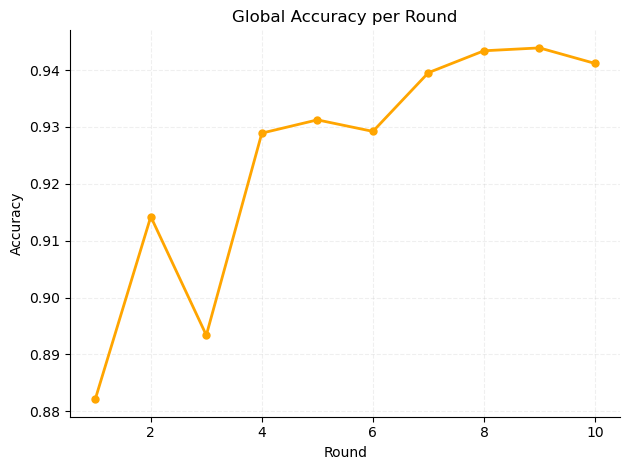

In [209]:
rounds = list(range(1, len(history.metrics_distributed["accuracy"]) + 1))
accuracies = [acc for _, acc in history.metrics_distributed["accuracy"]]

rounds_np = np.array(rounds)
accuracies_np = np.array(accuracies)

# Use linear interpolation instead of cubic spline
interpolator = interp1d(rounds_np, accuracies_np, kind='linear')
rounds_smooth = np.linspace(rounds_np.min(), rounds_np.max(), 100)
accuracies_smooth = interpolator(rounds_smooth)

fig, ax = plt.subplots(facecolor='white')  
ax.plot(rounds_smooth, accuracies_smooth, color='orange', linewidth=2)
ax.plot(rounds_np, accuracies_np, marker='.', linestyle='None', color='orange', markersize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and grid
ax.set_title("Global Accuracy per Round")
ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


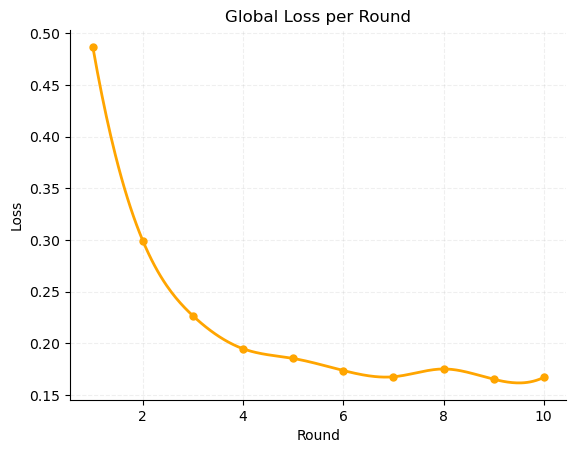

In [181]:
global_loss = [loss for _, loss in history.losses_distributed]
rounds = list(range(1, len(global_loss) + 1))

rounds_np = np.array(rounds)
losses_np = np.array(global_loss)

rounds_smooth = np.linspace(rounds_np.min(), rounds_np.max(), 300)
spline = make_interp_spline(rounds_np, losses_np, k=3)
losses_smooth = spline(rounds_smooth)

fig, ax = plt.subplots(facecolor='white')
ax.plot(rounds_smooth, losses_smooth, color='orange', linewidth=2)
ax.plot(rounds_np, losses_np, marker='.', linestyle='None', color='orange', markersize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Global Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
ax.grid(True, linestyle='--', alpha=0.2)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

for cid in range(NUM_CLIENTS):
    log_file = f"output/FedAvgM/client_{cid}_clients_{NUM_CLIENTS}.epochs_accuracy_FedAvgM.log"
    if os.path.exists(log_file):
        with open(log_file, "r") as f:
            accuracies = [float(line.strip()) for line in f.readlines()]
            plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', label=f"Client {cid +1}")

plt.title("Client Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()